# Practice: Neural Network - Feed Forward

## Step 1: Install Keras and Import Libraries

__Keras Documentation:__

https://keras.io/getting-started/sequential-model-guide/

__Type the following line in Terminal:__

conda install -c conda-forge keras

__Libraries for Neural Network__

In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

In [6]:
import statsmodels as sm 
import statsmodels.api as smt

import warnings
warnings.simplefilter('ignore')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 4 # set fig width and height in inches

## Step 2: Prepare the dataset

In [7]:
# Set the RNG seed so we get the same results everytime
np.random.seed(1) 

# Read the data
data = pd.read_csv('international-airline-passengers.csv', usecols=[1]) # Use the value in column index 1 as column title
data = data.dropna()  # Drop all Nans
data = data.values # Make sure to convert the pandas dataframe to an array by using .values attribute. 
                   # Keras expects array data type, not dataframe or series.

## Step 3: EDA
### (3.1) Plot of original series

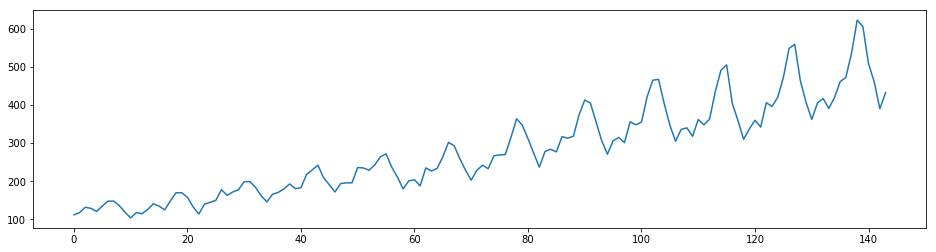

In [8]:
plt.figure()
plt.plot(data)
plt.show()

### (3.2) Estimate the lag dependence (ACF and PACF plots)

The length of this window depends on a few things. 

__Seasonality?:__ First we must consider whether there is seasonality in our data. If there is then to model the seasonality in our network the input feature windows must be at least as long as the seasonal period. In this dataset the seasonal period is 12 months. 

__The Tradeoff:__ In general the more data you can input into your neural network the more accurate the predictions will become. However increasing the amount of data also increases training time and memory requirements. So we must make a tradeoff.

__Check the ACF and PACF plots:__

(say) we decide the lag terms should be 12 (i.e. p = 12)

Do we need to differencing? Simply the the ARIMA result?

### Step 4: Pre-processing: Scaling
Neural networks normally work best with scaled data, especially when we use the sigmoid or tanh activation function.  It is best practice to scale the data to the range of 0-to-1. This can be easily done by using scikit-learn's MinMaxScaler.

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

### Step 5: Preparing training and validation data (based on the determined lag "p")

In [10]:
# Prepare training and validation set
time_window = 12 # the determined lag "p"

Xall, Yall = [], []
for i in range(time_window, len(data)): # i from p=12 to n-1=143
    Xall.append(data[i-time_window:i, 0]) # (n-p)个arrays from index 0~p-1 to index n-p-1 ~ n-2
    Yall.append(data[i, 0]) # (n-p)个floats from index p to index n-1

In [11]:
# Convert data type from list to array
Xall = np.array(Xall)    
Yall = np.array(Yall)

In [12]:
# Train-test split
train_size = int(len(Xall) * 0.8)
test_size = len(Xall) - train_size
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

### Step 6: Define the architecture (Feed-Forward NN Model)

To begin with, we illustrate an example of using:
- Lag: p = 12 (already specified)
- Depth: number of hidden layers = 1
- Width: k = 20

The tuning of these parameters is for the model selection part.

__Model Type:__ The __Sequential model__ is a linear stack of layers. We can create a Sequential model as below

In [13]:
model = Sequential()

__Inputs:__ After creating the model, then passing a list of layer instances to the constructor as below

add layers via the .add() method

__Dense layer:__ A linear operation in which every input is connected to every output by a weight (so there are n_inputs * n_outputs weights - which can be a lot!). Generally followed by a non-linear activation function

__Specifying the input shape:__ The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. 

__Specifying the activation function:__ We only learned relu & sigmoid

In [14]:
# Add the hidden layer
model.add(Dense(20, input_dim=time_window, activation='relu')) # specify width (the number of neurons) to be 20

In [15]:
# Add the output layer
model.add(Dense(1))

### Step 7: Compile

The next step is to compile, which means to check the network for potential errors and to decide on a loss function (i.e. configure a learning process) (the type of penalty applied to the error) and the optimization algorithm.

Specifying:
- a loss function
- an optimiser

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam')

### Step 8: Train NN

Finally we can train our network. By training we mean to learn the optimal weights of the network edges (links between neurons).
To train we must specify some training features (predictors, called Xtrain) and targets (predictions, called Ytrain) and some other tuning parameters which will be explained later

__Documentation:__

https://keras.io/models/sequential/

Specifying:

- __batch_size: __ Integer or None. Number of samples per gradient update (i.e. in each Epoch - forward/backward pass of the network). If unspecified, batch_size will default to 32. (iterating on the data in batches of 32 samples).
- __epochs: __ Integer. 
    - Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch,  epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.
    - "Typically, you have a fixed training set for your neural network. Training your network on each item of the set once is an epoch. So, if you want to teach your network to recognize the letters of the alphabet, 100 epochs would mean you have 2600 individual training trials". Just iterations
    - An Epoch is a forward/backward pass of all batches. If you increase the Epoch’s you should see an improvement in accuracy since it is refining the model parameters each time.
- __verbose: __Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
- __validation split: __ percentage of data used as validation set

In [17]:
model.fit(Xtrain, Ytrain, epochs=100, batch_size=32, verbose=0, validation_split=0.05)
# Train the model, iterating on the data in batches of 32 samples

### Step 9: One Step Forecast (in-sample forecast) - get training error
We can first check how well the model fits our data by doing a one-step prediction. This uses all available observations i.e. feeds the neural network with actual observations and we ask for its prediction.

In [18]:
allPredict = model.predict(Xall) # Generate Predictions for training set
allPredictPlot = scaler.inverse_transform(allPredict) # Transform back

plt.figure()
plt.plot(scaler.inverse_transform(data), label='True Data') # Plot orginal data - transformed back
plt.plot(np.arange(time_window,len(data)),allPredictPlot, label='One-Step Prediction') # Plot predictions
plt.legend()
trainScore = math.sqrt(mean_squared_error(Ytrain, allPredict[:train_size,0])) # Calculate training RMSE
print('Training Data RMSE: {0:.2f}'.format(trainScore))

Training Data RMSE: 0.03


### Step 10: Dynamic Forecast (out of sample forecast) - get test error
In the real world we do not have access to the future values so we have to do a dynamic forecast. This forecast uses observations up to some time point. From that point onwards we append our latest forecast to the list and use a combination of real values and estimated values. Eventually if the forecast length exceeds the window of values used we will be only using estimated values.

In [19]:
dynamic_prediction = np.copy(data[:len(data) - test_size])

for i in range(len(data) - test_size, len(data)): # i from 117 ~ 143
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window)) # Get index 105 ~ 116 ...
    next_pred = model.predict(last_feature) # Use index 105 ~ 116 to predict index 117 ...
    dynamic_prediction = np.append(dynamic_prediction,next_pred) # Index 117 join the big family

dynamic_prediction = dynamic_prediction.reshape(-1,1) # reshape to 2-D
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)


plt.figure()
plt.plot(scaler.inverse_transform(data[:len(data) - test_size]), label='Training Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1), 
         scaler.inverse_transform(data[-test_size:]), 
         label='Testing Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1),
         dynamic_prediction[-test_size:], 
         label='Out of Sample Prediction')
plt.legend(loc = "upper left")
testScore = math.sqrt(mean_squared_error(Ytest, dynamic_prediction[-test_size:]))
print('Dynamic Forecast RMSE: {0:.2f}'.format(testScore))

Dynamic Forecast RMSE: 452.07
